In [210]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, mannwhitneyu

In [211]:
# Import the data
df = pd.read_csv(r'C:\Users\Lindsay\Github\MEA_data\Before Hypoxia Plate 4(001)(000)_spike_counts.csv')

In [212]:
# Deleting empty columns
df = df.dropna(axis=1, how='all')

# deleting the unnamed column
df = df.drop('Unnamed: 2', axis=1)

df.head()

,Interval Start (S),Interval End (S),A1,A1_11,A1_12,A1_13,A1_14,A1_15,A1_16,A1_17,...,A1_77,A1_78,A1_81,A1_82,A1_83,A1_84,A1_85,A1_86,A1_87,A1_88
0,00000.000000,00001.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00001.000000,00002.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00002.000000,00003.000000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00003.000000,00004.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00004.000000,00005.000000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The highlighted text is a line of Python code that uses the `dropna` method from the pandas library to remove columns from a DataFrame (`df`) that contain only `NaN` (Not a Number) values.

Explanation:
`df.dropna(axis=1, how='all')`:
`df`: The DataFrame from which columns are being removed.
`dropna`: A method to remove missing values.
`axis=1`: Specifies that the operation should be performed on columns (if `axis=0`, it would operate on rows).
`how='all'`: Specifies that only columns where all values are NaN should be removed.

In [213]:
# Check the data types
print('Before converting the data types:')
print("Data type of 'Interval Start (S)':", type(df['Interval Start (S)'][0]))
print("Data type of 'Interval End (S)':", type(df['Interval End (S)'][0]))
print("Data type of 'A1_11':", type(df['A1_11'][0]))

# Python is seeing the intervals as strings instead of floats

Before converting the data types:
Data type of 'Interval Start (S)': <class 'str'>
Data type of 'Interval End (S)': <class 'str'>
Data type of 'A1_11': <class 'numpy.float64'>


In [214]:
# Convert the columns to numeric types
df['Interval Start (S)'] = pd.to_numeric(df['Interval Start (S)'], errors='coerce')
df['Interval End (S)'] = pd.to_numeric(df['Interval End (S)'], errors='coerce')

# Ensure the values are numerical
interval_start = df['Interval Start (S)'].iloc[0]
interval_end = df['Interval End (S)'].iloc[0]

# Check the data types
print("Data type of 'Interval Start (S)':", interval_start, type(interval_start))
print("Data type of 'Interval End (S)':", interval_end, type(interval_end))

Data type of 'Interval Start (S)': 0.0 <class 'numpy.float64'>
Data type of 'Interval End (S)': 1.0 <class 'numpy.float64'>


The +1 is added to the `interval_end.max()` to ensure that the last interval end is included in the range of time bins. This is because np.arange generates values in the half-open interval `[start, stop)`, meaning it includes the start value but excludes the stop value. By adding `+1` to `interval_end.max()`, you ensure that the last interval end is included in the time bins.

In [215]:
# Define the bin width (e.g., 1 s)
bin_width = 1.0

# Columns to process
columns_to_process = df.columns[22:23].tolist()

print(columns_to_process)

# Initialize a dictionary to accumulate spike counts for each column
spike_counts = {col: {} for col in columns_to_process}


['A1_34']


In [216]:
# Initialize spike_counts dictionary
spike_counts = {col: {} for col in columns_to_process}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    interval_start = row['Interval Start (S)']
    interval_end = row['Interval End (S)']
    
    for col in columns_to_process:
        spike_count = row[col]
        
        # Define the time bins for the current interval
        try:
            time_bins = np.arange(interval_start, interval_end + bin_width, bin_width)
        except ValueError as e:
            continue
        
        # Accumulate spike counts in the bins
        for bin_start in time_bins[:-1]:
            if bin_start not in spike_counts[col]:
                spike_counts[col][bin_start] = 0
            spike_counts[col][bin_start] += spike_count

# Convert the dictionaries to sorted lists of bins and counts
sorted_bins = {col: sorted(spike_counts[col].keys()) for col in columns_to_process}
sorted_counts = {col: [spike_counts[col][bin_start] for bin_start in sorted_bins[col]] for col in columns_to_process}

In [217]:
# Determine the number of columns to process
num_columns = len(columns_to_process)

# Calculate the number of rows and columns for the subplot grid
num_cols = math.ceil(math.sqrt(num_columns))  # Number of columns in the grid
num_rows = math.ceil(num_columns / num_cols)  # Calculate the number of rows needed

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 1
Number of columns: 1


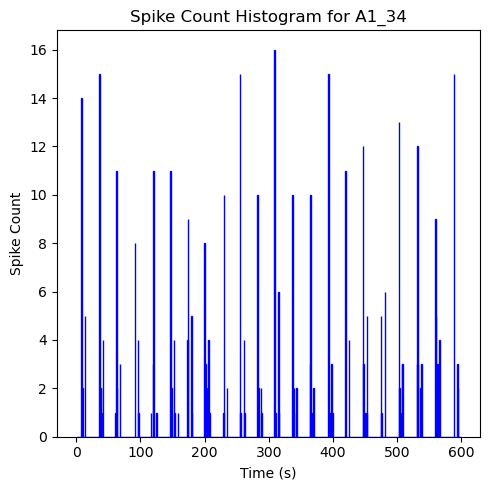

In [218]:
# Create a figure and an array of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5), sharey=True)

# Ensure axs is always an array
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

# Flatten the array of subplots for easy iteration
axs = axs.flatten()

# Loop through each column to process
for index, col in enumerate(columns_to_process, 0):  # had to make this 0 bc it's usually 1
    # Calculate the row and column index for the subplot
    row_idx = num_rows - 1 - (index % num_rows)  # Reverse the row index
    col_idx = index // num_rows

    # Calculate the subplot index
    subplot_index = row_idx * num_cols + col_idx

    # Create a subplot for each column
    ax = axs[subplot_index]
    ax.hist(sorted_bins[col], bins=len(sorted_bins[col]), weights=sorted_counts[col], edgecolor='blue')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Spike Count')
    ax.set_title(f'Spike Count Histogram for {col}')

    # # Add a vertical span (vspan) to highlight a region
    # vspan_start = 1  # Start position of the vertical span
    # vspan_end = 300    # End position of the vertical span
    # ax.axvspan(vspan_start, vspan_end, color='lightgrey', alpha=0.5, zorder = 1)
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Fine-tune the spacing
plt.show()

## Comparing the mean firing rate of each electrode

In [219]:
mean_firing_rate = {}
first_segment_duration = 300
last_segment_duration = 200

for col in columns_to_process:
    # Calculate total duration
    total_duration = sorted_bins[col][-1] - sorted_bins[col][0] + bin_width  # Assuming bins are in seconds

    # Determine the indices for the first and last segments
    first_segment_end_idx = np.searchsorted(sorted_bins[col], first_segment_duration)
    last_segment_start_idx = np.searchsorted(sorted_bins[col], total_duration - last_segment_duration)

    # Calculate the mean firing rate for the first 300 seconds
    first_segment_spikes = sum(sorted_counts[col][:first_segment_end_idx])
    first_segment_total_duration = sorted_bins[col][first_segment_end_idx - 1] - sorted_bins[col][0] + bin_width
    first_segment_mean_firing_rate = round(first_segment_spikes / first_segment_total_duration, 2) if first_segment_total_duration > 0 else 0

    # Calculate the mean firing rate for the last 200 seconds
    last_segment_spikes = sum(sorted_counts[col][last_segment_start_idx:])
    last_segment_total_duration = sorted_bins[col][-1] - sorted_bins[col][last_segment_start_idx] + bin_width
    last_segment_mean_firing_rate = round(last_segment_spikes / last_segment_total_duration, 2) if last_segment_total_duration > 0 else 0

    # Store the results in the dictionary
    mean_firing_rate[col] = {
        'first_300_seconds': first_segment_mean_firing_rate,
        'last_200_seconds': last_segment_mean_firing_rate
    }

print(mean_firing_rate)

{'A1_34': {'first_300_seconds': 0.66, 'last_200_seconds': 0.68}}


In [220]:
# Change the duration of the first and last segments here
mean_firing_rate = {}
first_segment_duration = 300
last_segment_duration = 200

# Initialize lists to store the mean firing rates
first_segment_means = []
last_segment_means = []
columns = []

for col in columns_to_process:
    # Calculate total duration
    total_duration = sorted_bins[col][-1] - sorted_bins[col][0] + bin_width  # Assuming bins are in seconds

    # Determine the indices for the first and last segments
    first_segment_end_idx = np.searchsorted(sorted_bins[col], first_segment_duration)
    last_segment_start_idx = np.searchsorted(sorted_bins[col], total_duration - last_segment_duration)

    # Calculate the mean firing rate for the first segment
    first_segment_spikes = sum(sorted_counts[col][:first_segment_end_idx])
    first_segment_total_duration = sorted_bins[col][first_segment_end_idx - 1] - sorted_bins[col][0] + bin_width
    first_segment_mean_firing_rate = round(first_segment_spikes / first_segment_total_duration, 2) if first_segment_total_duration > 0 else 0

    # Calculate the mean firing rate for the last segment
    last_segment_spikes = sum(sorted_counts[col][last_segment_start_idx:])
    last_segment_total_duration = sorted_bins[col][-1] - sorted_bins[col][last_segment_start_idx] + bin_width
    last_segment_mean_firing_rate = round(last_segment_spikes / last_segment_total_duration, 2) if last_segment_total_duration > 0 else 0

    # Append the results to the lists
    first_segment_means.append(first_segment_mean_firing_rate)
    last_segment_means.append(last_segment_mean_firing_rate)
    columns.append(col)

# Convert the lists to NumPy arrays
first_segment_means_array = np.array(first_segment_means)
last_segment_means_array = np.array(last_segment_means)
columns_array = np.array(columns)

# Create adaptable field names based on the durations
first_segment_field = f'first_{first_segment_duration}_seconds'
last_segment_field = f'last_{last_segment_duration}_seconds'

# Create a structured NumPy array to match the columns to the mean firing rates
dtype = [
    ('column', 'U20'), 
    (first_segment_field, 'f4'), 
    (last_segment_field, 'f4')
]
mean_firing_rate_array = np.zeros(len(columns), dtype=dtype)
mean_firing_rate_array['column'] = columns_array
mean_firing_rate_array[first_segment_field] = first_segment_means_array
mean_firing_rate_array[last_segment_field] = last_segment_means_array


# Print the structured NumPy array
print(mean_firing_rate_array)
print("The size of the mean_firing_rate_array is:", mean_firing_rate_array.size)

[('A1_34', 0.66, 0.68)]
The size of the mean_firing_rate_array is: 1


In [222]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr

# Assuming sorted_counts, sorted_bins, columns_to_process, and bin_width are already defined

sorted_counts = {col: [spike_counts[col][bin_start] for bin_start in sorted_bins[col]] for col in columns_to_process}

# Convert the sorted lists to NumPy arrays
sorted_bins_np = {col: np.array(sorted_bins[col]) for col in columns_to_process}
sorted_counts_np = {col: np.array(sorted_counts[col]) for col in columns_to_process}

mean_firing_rate = {}
first_segment_duration = 300
last_segment_duration = 200

first_segment_means_array = []
first_segment_spike_counts = []
last_segment_means_array = []
last_segment_spike_counts = []

In [223]:
for col in columns_to_process:
    # Calculate total duration
    total_duration = sorted_bins_np[col][-1] - sorted_bins_np[col][0] + bin_width  # Assuming bins are in seconds

    # Determine the indices for the first and last segments
    first_segment_end_idx = np.searchsorted(sorted_bins_np[col], first_segment_duration)
    last_segment_start_idx = np.searchsorted(sorted_bins_np[col], total_duration - last_segment_duration)

    # Calculate the mean firing rate for the first 300 seconds
    first_segment_spikes = sum(sorted_counts_np[col][:first_segment_end_idx])
    first_segment_total_duration = sorted_bins_np[col][first_segment_end_idx - 1] - sorted_bins_np[col][0] + bin_width
    first_segment_mean_firing_rate = round(first_segment_spikes / first_segment_total_duration, 2) if first_segment_total_duration > 0 else 0

    # Calculate the mean firing rate for the last 200 seconds
    last_segment_spikes = sum(sorted_counts_np[col][last_segment_start_idx:])
    last_segment_total_duration = sorted_bins_np[col][-1] - sorted_bins_np[col][last_segment_start_idx] + bin_width
    last_segment_mean_firing_rate = round(last_segment_spikes / last_segment_total_duration, 2) if last_segment_total_duration > 0 else 0

    # Store the results in the dictionary
    mean_firing_rate[col] = {
        'first_300_seconds': first_segment_mean_firing_rate,
        'last_200_seconds': last_segment_mean_firing_rate
    }

    # Store the segment means and spike counts in arrays
    first_segment_means_array.append(first_segment_mean_firing_rate)
    first_segment_spike_counts.append(first_segment_spikes)
    last_segment_means_array.append(last_segment_mean_firing_rate)
    last_segment_spike_counts.append(last_segment_spikes)

print(mean_firing_rate)

{'A1_34': {'first_300_seconds': 0.66, 'last_200_seconds': 0.68}}


In [224]:
# Convert the segment means and spike counts into a NumPy array for easier manipulation
data = [
    (
        col, 
        first_segment_means_array[i], 
        first_segment_spike_counts[i], 
        last_segment_means_array[i], 
        last_segment_spike_counts[i]
    )
    for i, col in enumerate(columns_to_process)
]

print(data)

[('A1_34', 0.66, 198.0, 0.68, 136.0)]


In [225]:
# Convert the list of tuples to a NumPy array
data_array = np.array(data, dtype=object)

print(data_array)

[['A1_34' 0.66 198.0 0.68 136.0]]


In [226]:
first_segment_duration = 300
last_segment_duration = 200

for col in columns_to_process:
    # Calculate total duration
    total_duration = sorted_bins_np[col][-1] - sorted_bins_np[col][0] + bin_width  # Assuming bins are in seconds

    # Determine the indices for the first and last segments
    first_segment_end_idx = np.searchsorted(sorted_bins_np[col], first_segment_duration)
    last_segment_start_idx = np.searchsorted(sorted_bins_np[col], total_duration - last_segment_duration)

    # Extract the spike counts for the first and last segments
    first_segment_counts = sorted_counts_np[col][:first_segment_end_idx]
    last_segment_counts = sorted_counts_np[col][last_segment_start_idx:]

    # Calculate the mean firing rate for the first 300 seconds
    first_segment_spikes = np.sum(first_segment_counts)
    first_segment_total_duration = sorted_bins_np[col][first_segment_end_idx - 1] - sorted_bins_np[col][0] + bin_width
    first_segment_mean_firing_rate = round(first_segment_spikes / first_segment_total_duration, 2) if first_segment_total_duration > 0 else 0

    # Calculate the mean firing rate for the last 200 seconds
    last_segment_spikes = np.sum(last_segment_counts)
    last_segment_total_duration = sorted_bins_np[col][-1] - sorted_bins_np[col][last_segment_start_idx] + bin_width
    last_segment_mean_firing_rate = round(last_segment_spikes / last_segment_total_duration, 2) if last_segment_total_duration > 0 else 0

# Print mean firing rates for the columns
print(f'Mean Firing Rate for the first 300 seconds: {first_segment_mean_firing_rate:.2f} Hz')
print(f'Mean Firing Rate for the last 200 seconds: {last_segment_mean_firing_rate:.2f} Hz')


Mean Firing Rate for the first 300 seconds: 0.66 Hz
Mean Firing Rate for the last 200 seconds: 0.68 Hz


In [227]:
# Perform normality test using Shapiro-Wilk test
_, p_value_first_segment = shapiro(first_segment_counts)
_, p_value_last_segment = shapiro(last_segment_counts)

print(f'Shapiro test p-value for Channel 1: {p_value_first_segment:.3e}')
print(f'Shapiro test p-value for Channel 2: {p_value_last_segment:.3e}')

# Write a print statement if the channel data is normal or not
if p_value_first_segment > 0.05:
    print('Channel 1 data is normally distributed')
else:
    print('Channel 1 data is not normally distributed')

Shapiro test p-value for Channel 1: 1.233e-31
Shapiro test p-value for Channel 2: 2.262e-26


In [228]:
#It works for one column but not for multiple columns


# Decide on the test based on normality
if p_value_first_segment > 0.05 and p_value_last_segment > 0.05:
    # Both segments are normally distributed, perform paired t-test
    t_stat, p_value = ttest_rel(first_segment_counts, last_segment_counts)
    test_name = "Paired t-test"
else:
    # At least one segment is not normally distributed, perform Mann-Whitney U test
    t_stat, p_value = mannwhitneyu(first_segment_counts, last_segment_counts)
    test_name = "Mann-Whitney U test"

print(f"{test_name} results for {col}:")
print(f"Test Statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")
print()  # Blank line for readability

Mann-Whitney U test results for A1_34:
Test Statistic: 30209.500
P-value: 0.830



In [229]:
import numpy as np
from scipy.stats import ttest_rel, mannwhitneyu, shapiro

# Assuming sorted_counts, sorted_bins, columns_to_process, and bin_width are already defined

sorted_counts = {col: [spike_counts[col][bin_start] for bin_start in sorted_bins[col]] for col in columns_to_process}

# Convert the sorted lists to NumPy arrays
sorted_bins_np = {col: np.array(sorted_bins[col]) for col in columns_to_process}
sorted_counts_np = {col: np.array(sorted_counts[col]) for col in columns_to_process}

first_segment_duration = 300
last_segment_duration = 200

for col in columns_to_process:
    # Calculate total duration
    total_duration = sorted_bins_np[col][-1] - sorted_bins_np[col][0] + bin_width  # Assuming bins are in seconds

    # Determine the indices for the first and last segments
    first_segment_end_idx = np.searchsorted(sorted_bins_np[col], first_segment_duration)
    last_segment_start_idx = np.searchsorted(sorted_bins_np[col], total_duration - last_segment_duration)

    # Ensure indices are within bounds
    if first_segment_end_idx == 0 or last_segment_start_idx >= len(sorted_counts_np[col]):
        print(f"Skipping column {col} due to insufficient data in segments.")
        continue

    # Extract the spike counts for the first and last segments
    first_segment_counts = sorted_counts_np[col][:first_segment_end_idx]
    last_segment_counts = sorted_counts_np[col][last_segment_start_idx:]

    # Ensure segments are not empty
    if len(first_segment_counts) == 0 or len(last_segment_counts) == 0:
        print(f"Skipping column {col} due to empty segments.")
        continue

    # Check normality using the Shapiro-Wilk test
    first_segment_normality = shapiro(first_segment_counts)
    last_segment_normality = shapiro(last_segment_counts)

    print(f"Normality test results for {col}:")
    print(f"First segment p-value: {first_segment_normality.pvalue:.3e}")
    print(f"Last segment p-value: {last_segment_normality.pvalue:.3e}")

    # Decide on the test based on normality
    if first_segment_normality.pvalue > 0.05 and last_segment_normality.pvalue > 0.05:
        # Both segments are normally distributed, perform paired t-test
        t_stat, p_value = ttest_rel(first_segment_counts, last_segment_counts)
        test_name = "Paired t-test"
    else:
        # At least one segment is not normally distributed, perform Mann-Whitney U test
        t_stat, p_value = mannwhitneyu(first_segment_counts, last_segment_counts)
        test_name = "Mann-Whitney U test"

    print(f"{test_name} results for {col}:")
    print(f"Test Statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.3f}")
    print()  # Blank line for readability

Normality test results for A1_34:
First segment p-value: 1.233e-31
Last segment p-value: 2.262e-26
Mann-Whitney U test results for A1_34:
Test Statistic: 30209.500
P-value: 0.830



In [230]:
import numpy as np
from scipy.stats import ttest_rel, mannwhitneyu, shapiro

# Assuming sorted_counts, sorted_bins, columns_to_process, and bin_width are already defined

sorted_counts = {col: [spike_counts[col][bin_start] for bin_start in sorted_bins[col]] for col in columns_to_process}

# Convert the sorted lists to NumPy arrays
sorted_bins_np = {col: np.array(sorted_bins[col]) for col in columns_to_process}
sorted_counts_np = {col: np.array(sorted_counts[col]) for col in columns_to_process}

first_segment_duration = 300
last_segment_duration = 200

for col in columns_to_process:
    print(f"Processing column: {col}")
    
    # Calculate total duration
    total_duration = sorted_bins_np[col][-1] - sorted_bins_np[col][0] + bin_width  # Assuming bins are in seconds
    print(f"Total duration for {col}: {total_duration}")

    # Determine the indices for the first and last segments
    first_segment_end_idx = np.searchsorted(sorted_bins_np[col], first_segment_duration)
    last_segment_start_idx = np.searchsorted(sorted_bins_np[col], total_duration - last_segment_duration)
    print(f"First segment end index for {col}: {first_segment_end_idx}")
    print(f"Last segment start index for {col}: {last_segment_start_idx}")

    # Ensure indices are within bounds
    if first_segment_end_idx == 0 or last_segment_start_idx >= len(sorted_counts_np[col]):
        print(f"Skipping column {col} due to insufficient data in segments.")
        continue

    # Extract the spike counts for the first and last segments
    first_segment_counts = sorted_counts_np[col][:first_segment_end_idx]
    last_segment_counts = sorted_counts_np[col][last_segment_start_idx:]
    print(f"First segment counts for {col}: {first_segment_counts}")
    print(f"Last segment counts for {col}: {last_segment_counts}")

    # Ensure segments are not empty
    if len(first_segment_counts) == 0 or len(last_segment_counts) == 0:
        print(f"Skipping column {col} due to empty segments.")
        continue

    # Check normality using the Shapiro-Wilk test
    first_segment_normality = shapiro(first_segment_counts)
    last_segment_normality = shapiro(last_segment_counts)

    print(f"Normality test results for {col}:")
    print(f"First segment p-value: {first_segment_normality.pvalue:.3e}")
    print(f"Last segment p-value: {last_segment_normality.pvalue:.3e}")

    # Decide on the test based on normality
    if first_segment_normality.pvalue > 0.05 and last_segment_normality.pvalue > 0.05:
        # Both segments are normally distributed, perform paired t-test
        t_stat, p_value = ttest_rel(first_segment_counts, last_segment_counts)
        test_name = "Paired t-test"
    else:
        # At least one segment is not normally distributed, perform Mann-Whitney U test
        t_stat, p_value = mannwhitneyu(first_segment_counts, last_segment_counts)
        test_name = "Mann-Whitney U test"

    print(f"{test_name} results for {col}:")
    print(f"Test Statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.3f}")
    print()  # Blank line for readability

Processing column: A1_34
Total duration for A1_34: 600.0
First segment end index for A1_34: 300
Last segment start index for A1_34: 400
First segment counts for A1_34: [ 0.  0.  0.  0.  0.  0.  0.  0. 14.  2.  0.  0.  0.  5.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 15.  2.  2.  1.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1. 11.  2.  0.  0.  0.  0.  3.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  8.  0.  0.  0.  0.  4.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  3. 11.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. 11.  2.  0.  0.  0.  4.  1.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  9.  0.  0.  0.  0.  5.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  8.  3.  0.  2.  0. 

In [231]:
for i, channel_data in enumerate(data_array):
    channel_name = channel_data[0]
    first_mean_firing_rate = channel_data[1]
    last_mean_firing_rate = channel_data[3]
    # Output descriptive statistics for each channel (as previously printed)
    print(f"Statistics for {channel_name} - First Segment:")
    print(f"Mean Firing Rate: {first_mean_firing_rate}")
    print(f"Statistics for {channel_name} - Last Segment:")
    print(f"Mean Firing Rate: {last_mean_firing_rate}")
    
    # Compute the absolute difference (delta) and percentage change
    delta = last_mean_firing_rate - first_mean_firing_rate
    percentage_change = (delta / first_mean_firing_rate * 100) if first_mean_firing_rate != 0 else float('inf')

    print(f"Change in Firing Rate for {channel_name}:")
    print(f"Absolute Difference (Delta): {delta}")
    print(f"Percentage Change: {percentage_change}%")
    print()  # Blank line for readability

Statistics for A1_34 - First Segment:
Mean Firing Rate: 0.66
Statistics for A1_34 - Last Segment:
Mean Firing Rate: 0.68
Change in Firing Rate for A1_34:
Absolute Difference (Delta): 0.020000000000000018
Percentage Change: 3.030303030303033%



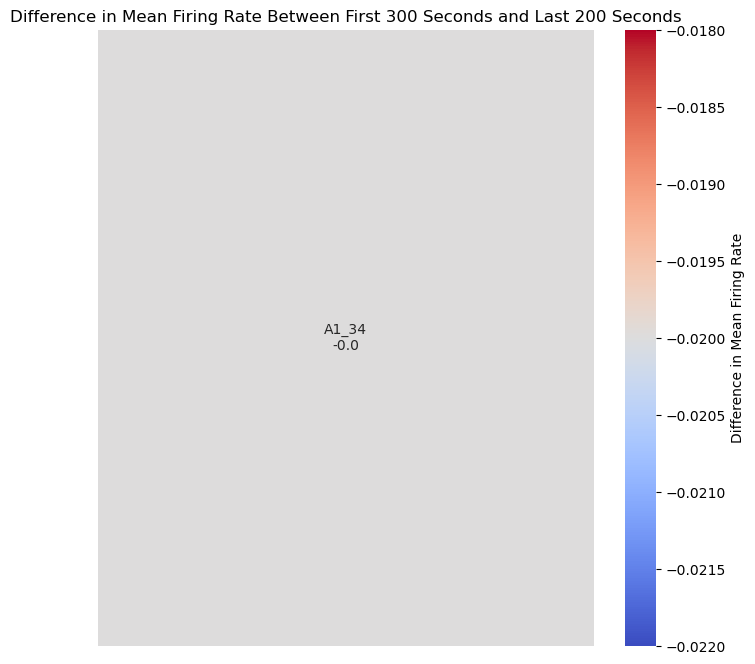

In [232]:
# Calculate the difference between the first and last segments
difference_array = np.array(first_segment_means_array) - np.array(last_segment_means_array)

# Determine the size of the reshaped array
num_columns = len(columns_to_process)
side_length = int(np.ceil(np.sqrt(num_columns)))

# Pad the arrays to make them square if necessary
pad_size = side_length**2 - num_columns
difference_array_padded = np.pad(difference_array, (0, pad_size), mode='constant', constant_values=np.nan)
columns_array_padded = np.pad(np.array(columns_to_process), (0, pad_size), mode='constant', constant_values='')

# Reshape the arrays to the determined size
difference_matrix = difference_array_padded.reshape(side_length, side_length)
columns_matrix = columns_array_padded.reshape(side_length, side_length)

# Transpose the matrices to count upwards
difference_matrix = difference_matrix.T
columns_matrix = columns_matrix.T

# Flip the matrices vertically to start from the bottom-left corner
difference_matrix = np.flipud(difference_matrix)
columns_matrix = np.flipud(columns_matrix)

# Create a custom annotation array
annotation_array = np.array([[f'{columns_matrix[i, j]}\n{difference_matrix[i, j]:.1f}' if columns_matrix[i, j] else '' for j in range(side_length)] for i in range(side_length)])

# Create adaptable title based on the durations
difference_plot_title = f'Difference in Mean Firing Rate Between First {first_segment_duration} Seconds and Last {last_segment_duration} Seconds'

# Create a heatmap to visualize the differences with custom annotations
plt.figure(figsize=(8, 8))
sns.heatmap(difference_matrix, annot=annotation_array, fmt='', cmap='coolwarm', cbar_kws={'label': 'Difference in Mean Firing Rate'}, xticklabels=False, yticklabels=False)
plt.title(difference_plot_title)
plt.xlabel('')
plt.ylabel('')
plt.show()